# **MNIST Digits prediction with feed forward Neural Networks and CNNs**

import libraries and data

In [26]:
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn import metrics

Let's visualize what the data looks like


11490434/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


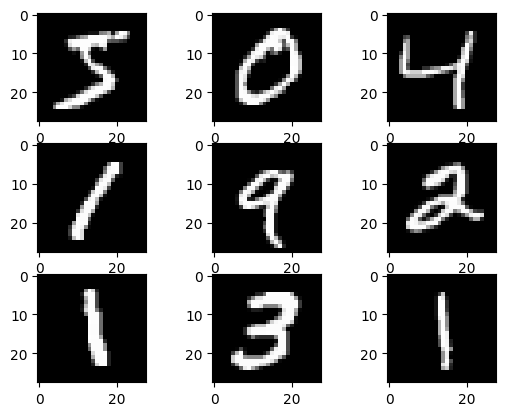

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

Let's ensure that the data is evenly distributed per class (if not, we would have to make corrections). We should expect that each class represents roughly 10% of the entire dataset.


In [3]:
for i in range(10):
  count_train = np.where(trainy == i)[0]
  count_test = np.where(testy == i)[0]

  print("Label %d - train: %.4f - test: %.4f" %(i, count_train.shape[0] / float(trainy.shape[0]), count_test.shape[0] / float(testy.shape[0]) ))

Label 0 - train: 0.0987 - test: 0.0980
Label 1 - train: 0.1124 - test: 0.1135
Label 2 - train: 0.0993 - test: 0.1032
Label 3 - train: 0.1022 - test: 0.1010
Label 4 - train: 0.0974 - test: 0.0982
Label 5 - train: 0.0903 - test: 0.0892
Label 6 - train: 0.0986 - test: 0.0958
Label 7 - train: 0.1044 - test: 0.1028
Label 8 - train: 0.0975 - test: 0.0974
Label 9 - train: 0.0992 - test: 0.1009


Ok, it looks good....we can work with these classes as is. Now let's start doing some prediction. We should split the training data into train and dev sets.


Now let's try building a 2-layer feed forward network to predict digits. Remember, each data point is a 28x28 image, so you will need to flatten it into a vector for a feed forward DNN.

In [11]:
from keras.src.utils.sidecar_evaluator import optimizer

#Define DNN class here
class DNN(nn.Module):
  def __init__(self,dim_input,dim_output):
    super(DNN,self).__init__()
    self.fc1=nn.Linear(dim_input,32)
    self.fc2=nn.Linear(32,dim_output)

  def forward(self,x):
    x=F.tanh(self.fc1(x))
    x=self.fc2(x)
    return x

  def train(self,X,y,epochs,batch_size):
    optimizer = optim.SGD(self.parameters(),lr=0.001)
    indices = np.arange(X.shape[0])
    criterion = nn.CrossEntropyLoss()
    for i in range(epochs):
      optimizer.zero_grad()
      idx = indices[:batch_size]
      batch_data = X[idx].reshape((batch_size, -1))
      batch_label = y[idx]

      logits = self.forward(batch_data)

      loss = criterion(logits, batch_label)
      loss.backward()
      optimizer.step()
      if i % 100 == 0:
        print("Iteration %d - loss: %.4f" %(i, loss))

  def test(self, test_data, test_labels, batch_size):
      k = 0
      all_probs = None
      while k < test_data.shape[0]:
          batch = test_data[k:k+batch_size,:,:] if k + batch_size <= test_data.shape[0] else test_data[k:,:,:]
          batch = batch.reshape((-1,test_data.shape[1]*test_data.shape[2]))
          logits = self.forward(batch)

          probs = F.softmax(logits).detach().numpy()

          all_probs = probs if all_probs is None else np.vstack((all_probs, probs))
          k += batch_size

      return all_probs


In [12]:
#Train DNN and predict on test
net = DNN(dim_input=(trainX.shape[1]*trainX.shape[2]), dim_output=10)

torch_trainX = torch.from_numpy(trainX).float()
torch_trainy = torch.from_numpy(trainy).long()
torch_testX = torch.from_numpy(testX).float()
torch_testy = torch.from_numpy(testy).long()

net.train(torch_trainX, torch_trainy, epochs=4000, batch_size=64)

Iteration 0 - loss: 2.3295
Iteration 100 - loss: 2.0590
Iteration 200 - loss: 1.9997
Iteration 300 - loss: 1.9422
Iteration 400 - loss: 1.8924
Iteration 500 - loss: 1.8363
Iteration 600 - loss: 1.7898
Iteration 700 - loss: 1.7491
Iteration 800 - loss: 1.7102
Iteration 900 - loss: 1.6653
Iteration 1000 - loss: 1.6289
Iteration 1100 - loss: 1.5883
Iteration 1200 - loss: 1.5551
Iteration 1300 - loss: 1.5232
Iteration 1400 - loss: 1.4925
Iteration 1500 - loss: 1.4602
Iteration 1600 - loss: 1.4315
Iteration 1700 - loss: 1.4033
Iteration 1800 - loss: 1.3762
Iteration 1900 - loss: 1.3501
Iteration 2000 - loss: 1.3249
Iteration 2100 - loss: 1.2992
Iteration 2200 - loss: 1.2648
Iteration 2300 - loss: 1.2410
Iteration 2400 - loss: 1.2169
Iteration 2500 - loss: 1.1951
Iteration 2600 - loss: 1.1740
Iteration 2700 - loss: 1.1515
Iteration 2800 - loss: 1.1318
Iteration 2900 - loss: 1.1127
Iteration 3000 - loss: 1.0942
Iteration 3100 - loss: 1.0763
Iteration 3200 - loss: 1.0589
Iteration 3300 - loss:

Report:
- precision
- recall
- ROC curve
- confusion matrix

In [13]:
#Enter code here
pred_prob = net.test(torch_testX, torch_testy, batch_size=64)
preds = np.argmax(pred_prob,axis=1)
p,r,f,_=precision_recall_fscore_support(testy,preds)

<ipython-input-11-ca0bdd51c3a3>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits).detach().numpy()


In [20]:
for i in range(p.shape[0]):
  print("Label: %d - Precision: %4f - Recall: %.4f - f1: % .4f" %(i,p[i],r[i],f[i]))

Label: 0 - Precision: 0.390027 - Recall: 0.5827 - f1:  0.4673
Label: 1 - Precision: 0.677419 - Recall: 0.8511 - f1:  0.7544
Label: 2 - Precision: 0.235294 - Recall: 0.0388 - f1:  0.0666
Label: 3 - Precision: 0.373253 - Recall: 0.5554 - f1:  0.4465
Label: 4 - Precision: 0.192852 - Recall: 0.2637 - f1:  0.2228
Label: 5 - Precision: 0.133333 - Recall: 0.0135 - f1:  0.0244
Label: 6 - Precision: 0.398570 - Recall: 0.6399 - f1:  0.4912
Label: 7 - Precision: 0.325301 - Recall: 0.0525 - f1:  0.0905
Label: 8 - Precision: 0.313589 - Recall: 0.0924 - f1:  0.1427
Label: 9 - Precision: 0.242424 - Recall: 0.4836 - f1:  0.3230


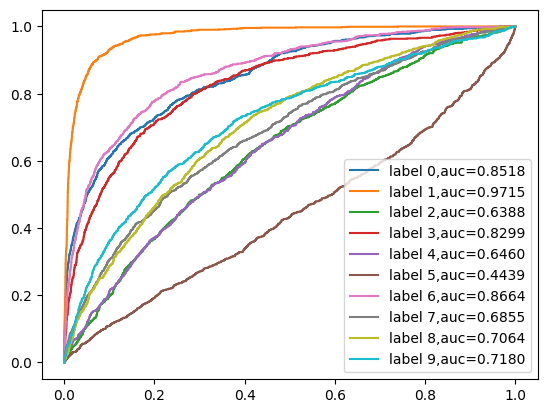

In [28]:
y = label_binarize(testy, classes=np.unique(testy))
plt.clf()
for i in range(10):
  fpr,tpr,_ = metrics.roc_curve(y[:,i],pred_prob[:,i])
  auc = metrics.roc_auc_score(y[:,i],pred_prob[:,i])
  plt.plot(fpr,tpr,label="label %d,auc=%.4f"%(i,auc))
plt.legend(loc=4)
plt.show()

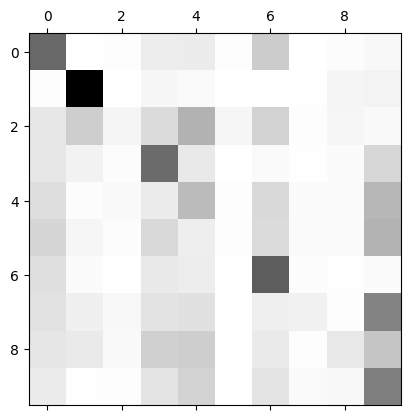

In [29]:
cm = metrics.confusion_matrix(testy,preds)
plt.matshow(cm,cmap='binary')

Now let's build a CNN network for image recognition.

In [58]:
# Define CNN
class Net(nn.Module):
  def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

  def train(self, X, y, epochs, batch_size):
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        indices = np.arange(X.shape[0])

        criterion = nn.CrossEntropyLoss()
        for i in range(epochs):
            optimizer.zero_grad()

            idx = indices[:batch_size]
            batch_data = X[idx]
            batch_label = y[idx]

            logits = self.forward(batch_data)

            loss = criterion(logits, batch_label)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
              print("Iteration %d - loss: %.4f" %(i, loss))

  def test(self, test_data, test_labels, batch_size):
      k = 0
      all_probs = None
      while k < test_data.shape[0]:
          batch = test_data[k:k+batch_size,:,:] if k + batch_size <= test_data.shape[0] else test_data[k:,:,:]
          logits = self.forward(batch)

          probs = F.softmax(logits).detach().numpy()

          all_probs = probs if all_probs is None else np.vstack((all_probs, probs))
          k += batch_size

      return all_probs

In [59]:
# Train CNN and predict on test
net = Net()

torch_trainX = torch.from_numpy(trainX).float()
torch_trainy = torch.from_numpy(trainy).long()
torch_testX = torch.from_numpy(testX).float()
torch_testy = torch.from_numpy(testy).long()

torch_trainX = torch.unsqueeze(torch_trainX, 1)
torch_testX = torch.unsqueeze(torch_testX, 1)

net.train(torch_trainX, torch_trainy, epochs=1000, batch_size=128)

Iteration 0 - loss: 3.8196
Iteration 100 - loss: 0.1137
Iteration 200 - loss: 0.0319
Iteration 300 - loss: 0.0165
Iteration 400 - loss: 0.0107
Iteration 500 - loss: 0.0078
Iteration 600 - loss: 0.0060
Iteration 700 - loss: 0.0048
Iteration 800 - loss: 0.0040
Iteration 900 - loss: 0.0034


Report:
- precision
- recall
- ROC curve
- confusion matrix

In [60]:
#Enter code here
pred_probs = net.test(torch_testX, torch_testy, batch_size=64)
preds = np.argmax(pred_probs, axis=1)
p, r, f, _ = precision_recall_fscore_support(testy, preds)

<ipython-input-58-42455bcfe63c>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits).detach().numpy()


At this point, you should have seen an improvement in performance when using CNN for images over DNN. Look into the performance metrics (specially the confusion matrix), and try to identify where CNNs made a difference in performance.

Are there specific number pairs that were difficult for DNN but improved on CNN?

Finally, pick a pair of classes that have high confusion an plot examples that are confusing between them. Can you see why the confusion happens? (This type of post-hoc investigation is typical in the industry to understand why/when something might fail, and work towards fixing those edge cases).



In [61]:
#Enter code here
for i in range(p.shape[0]):
  print("Label: %d - Precision: %.4f - Recall: %.4f - f1: %.4f"  %(i, p[i], r[i], f[i]))

Label: 0 - Precision: 0.7874 - Recall: 0.9449 - f1: 0.8590
Label: 1 - Precision: 0.8253 - Recall: 0.9410 - f1: 0.8794
Label: 2 - Precision: 0.6790 - Recall: 0.7093 - f1: 0.6938
Label: 3 - Precision: 0.6312 - Recall: 0.7881 - f1: 0.7010
Label: 4 - Precision: 0.6725 - Recall: 0.7026 - f1: 0.6873
Label: 5 - Precision: 0.6624 - Recall: 0.2904 - f1: 0.4037
Label: 6 - Precision: 0.8291 - Recall: 0.5772 - f1: 0.6806
Label: 7 - Precision: 0.7539 - Recall: 0.7121 - f1: 0.7324
Label: 8 - Precision: 0.7221 - Recall: 0.4856 - f1: 0.5807
Label: 9 - Precision: 0.4531 - Recall: 0.6650 - f1: 0.5390


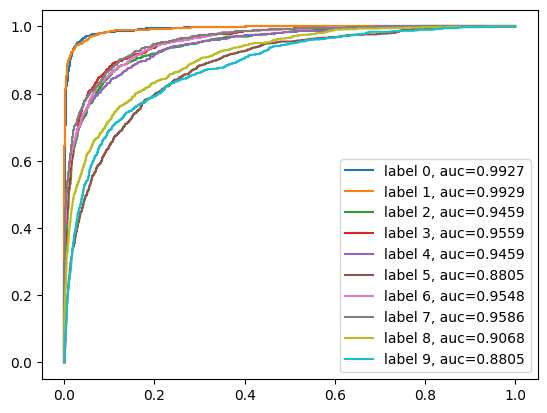

In [62]:
y = label_binarize(testy, classes=np.unique(testy))
plt.clf()
for i in range(10):
  fpr, tpr, _ = metrics.roc_curve(y[:,i],  pred_probs[:,i])
  auc = metrics.roc_auc_score(y[:,i], pred_probs[:,i])
  plt.plot(fpr,tpr,label="label %d, auc=%.4f" %(i, auc))
plt.legend(loc=4)
plt.show()

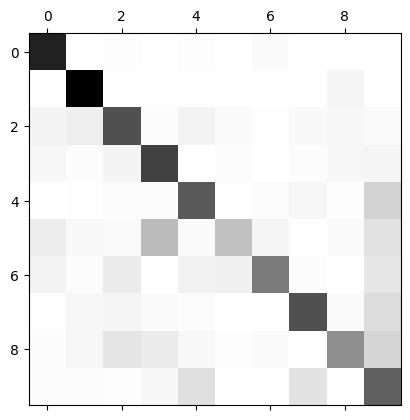

In [63]:
cm=metrics.confusion_matrix(testy,preds)
plt.matshow(cm, cmap='binary')